### Module import

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

### 1. Camera Calibration

In [42]:
objpoints = [] #3D dimension object, where z is the depth, index of chess board intersection, like (0,0,0), (1,0,0)...()
imgpoints = [] #this is 2D image object, the coordinates of the distorted images for each index points

In [43]:
def camera_calibration(nx, ny, i,objpoints,imgpoints):
    '''
    nx is the number of the intersection of chess in x direction 
    ny is the number of the intersection of chess in y direction
    i is the ith image to be calibrated
    
    There are about 20 chessboard images for calibaration purpose. For each image, store their objpoints
    and imgpoints, and use all these points together for camera calibration later. 
    '''
    Path = './camera_cal/'
        
    objp = np.zeros((ny*nx,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    cal1 = Path + f'calibration{i}.jpg'
    
    image = cv2.imread(cal1)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret1, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
 #   print(ret1)
    if ret1 == True:
        objpoints.append(objp)
    # Draw and display the corners
        img = cv2.drawChessboardCorners(image, (nx, ny), corners, ret1)
        imgpoints.append(corners)
      #  print(corners)
        return corners
    else:
        print(f'Warning: Corners NOT Found in calibration{i}.jpg!')
        return 0

#### Due to the bad quality of chessboard images, parameters from 3 caliration images were excluded.  

In [44]:
for i in range(1,21):
    camera_calibration(9,6,i,objpoints,imgpoints)

## Using the objpoints and imgpoints to calirate the camera and undistort the images

In [45]:
def undistort_image(objpoints, imgpoints,img_size=(720,1280)):
    #img_size = (image.shape[0],image.shape[1])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

### "mtx" and "dist" parameters found from chessboard image calibration

In [46]:
mtx, dist = undistort_image(objpoints, imgpoints,img_size=(720,1280))

### Unwarp image using Perspective transform function

In [47]:
def chessboard(corners,image):
    nx = 9
    offset = 75 # offset for dst points

    # x coordinate first, then y
    img_size = (image.shape[1],image.shape[0])
 #   print(img_size[0],img_size[1])
    # top left-> top right->bottom right->bottom left
    src = np.float32([corners[0], corners[nx-2], corners[-2], corners[-nx]])

    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
    return src, dst

In [48]:
def unwarp_image(image, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    img_size = (image.shape[1],image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

#### Compare original, undistorted, and unwarped images. It is clear to see that the processed images look more nature, and unditorted. 

Note: calibration 1, 4, 5 images had inregular corners, and they had to manually find the points, therefore they were not plotted here.  

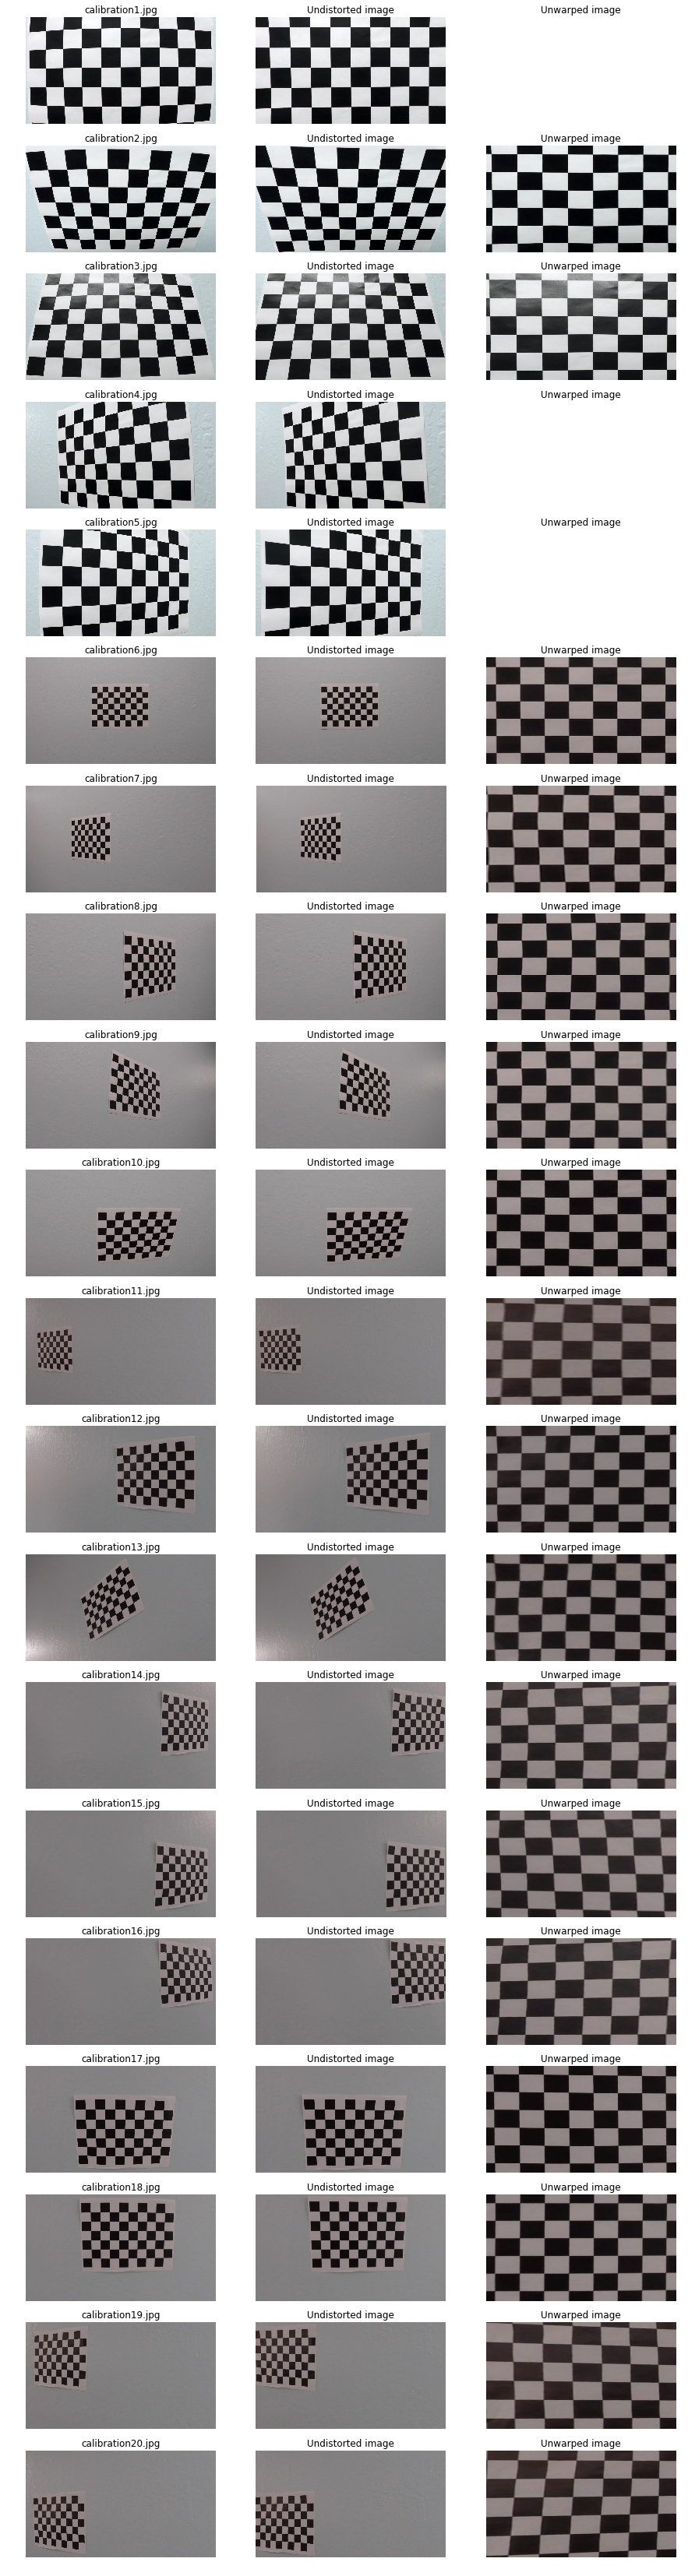

In [23]:
Path = './camera_cal/'
fig = plt.figure(figsize=(15,60))

for i in range(1,21):
    cal = Path + f'calibration{i}.jpg'
    img = cv2.imread(cal)
    fig.add_subplot(20,3,(i-1)*3 + 1)
    plt.title(f'calibration{i}.jpg')
    plt.axis('off')
    plt.imshow(img)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    fig.add_subplot(20,3,(i-1)*3 + 2)
    plt.title('Undistorted image')
    plt.axis('off')
    plt.imshow(undist)
    fig.add_subplot(20,3,(i-1)*3 + 3)
    plt.title('Unwarped image')
    plt.axis('off')
    corners = camera_calibration(9,6,i,objpoints,imgpoints)
    if isinstance(corners, int):
        print()       
    else:
        src,dst = chessboard(corners,img)
        plt.imshow(unwarp_image(undist,src,dst))

### Apply unwarp function to the test images to see if the function really works in real images

From the image comparisons below, the original images were well recovered to unwarped images. 

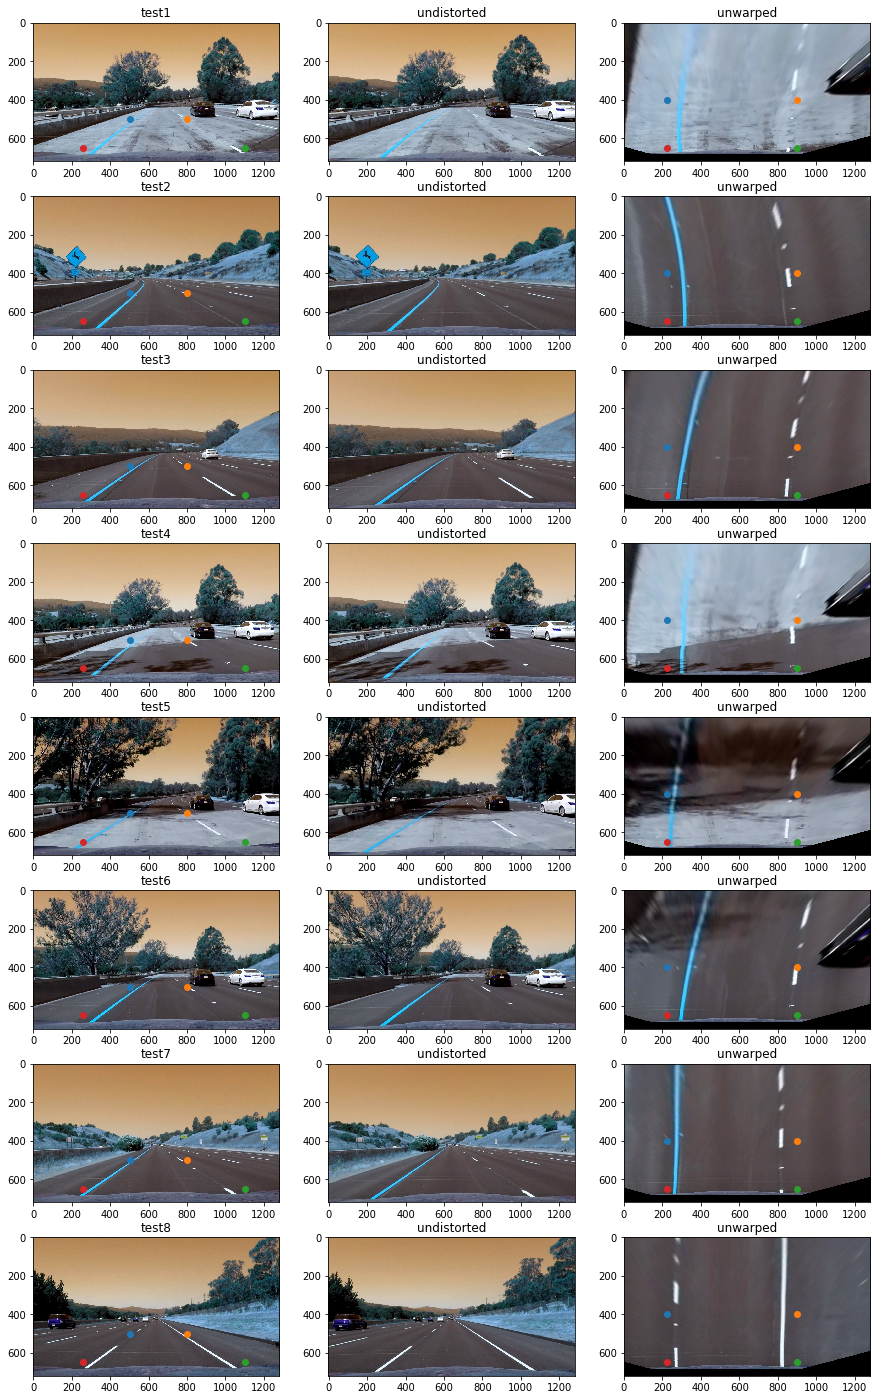

In [59]:
fig = plt.figure(figsize=(15,25))

for i in range(1,9):
    test = f'./test_images/test{i}.jpg'
    test = cv2.imread(test)
    
    fig.add_subplot(8,3,(i-1)*3+1)
    plt.plot(505,500,'o')
    plt.plot(800,500,'o')
    plt.plot(1100,650,'o')
    plt.plot(260,650,'o')
    plt.title(f'test{i}')
    plt.imshow(test, cmap = 'gray')
    
    fig.add_subplot(8,3,(i-1)*3+2)
    undistorted = cv2.undistort(test, mtx, dist, None, mtx)
    plt.title('undistorted')
    plt.imshow(undistorted, cmap = 'gray')
    
    fig.add_subplot(8,3,(i-1)*3+3)
    unwarped = unwarp_image(undistorted, src, dst)
    plt.title('unwarped')
    plt.plot(225,400,'o')
    plt.plot(900,400,'o')
    plt.plot(900,650,'o')
    plt.plot(225,650,'o')
    plt.imshow(unwarped, cmap = 'gray')

### Apply Sobel Operators to the images

##### The process is described briefly below:

1. Convert a colored image to gray
2. Apply Sobel operator to the gray image
3. Because Sobel operators applied, values of some pixels in the image were negative, which did not have much meanings in the context of a gray image. Therefore they were converted to positive values by apply abs function. 
4. In order to make the gradient image more clearly, use 1 to the pixel that are likely to be edges, and use 0 for the rest. 
5. Apply direction of the gradient to the image. 

Conclusion: even applied these processings, the lane lines of test1, test4, and test5 images were not well detected. By observing those images, we found they shared similiaries: shadows, strong sunlight, and color of the road surface. Therefore, other more processings, probably color processing, are needed for those images. 

##### HLS color processing:

After applying HLS color space, the lane lines were clearly detected regardless of shadow or sun light. 

In [49]:
def hls_threshold(img, thresh=(100, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [50]:
def gradient_hls_process(image, threshold1=(35,100), threshold2 = (0,np.pi/2)):
    # convert the colored image to gray
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=3)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    angel = np.arctan2(abs_sobely, abs_sobelx)
    direction =  np.zeros_like(angel)
    direction[(angel >= threshold2[0]) & (angel <= threshold2[1])] = 1    
    sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scale = np.max(sobelxy)/255    
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sobelxy = np.uint8(sobelxy/scale)    
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= threshold1[0]) & (scaled_sobelx <= threshold1[1])] = 1
    
    
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= threshold1[0]) & (scaled_sobely <= threshold1[1])] = 1

    sxybinary = np.zeros_like(sobelxy)
    sxybinary[(sobelxy >= threshold1[0]) & (sobelxy <= threshold1[1])] = 1
    
    combined = np.zeros_like(sobelxy)
    
    combined[((sxybinary == 1) & (direction == 1))|((sxbinary == 1) & (sybinary == 1))] = 1
    
    
    #convert the colored image from BGR to hls domain
    image_hls = hls_threshold(image,thresh=(150, 255))
    
    final = np.zeros_like(sobelxy)
    
    final[(combined == 1) | (image_hls == 1)] = 1
    return final

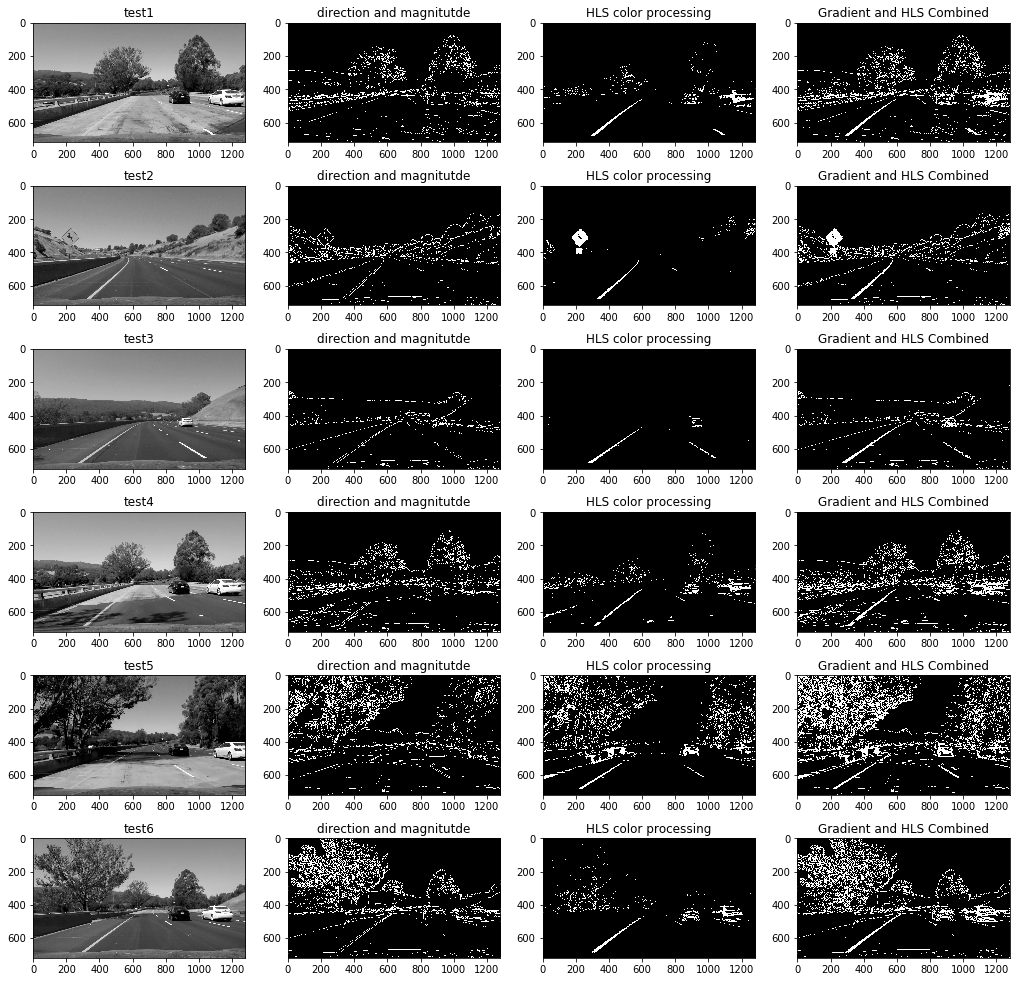

In [66]:
image_path = './test_images/'
fig = plt.figure(figsize=(17.5,17.5))

threshold1 = 35
threshold2 = 100

thresh1 = 0
thresh2 = np.pi/2
#testimg = []
for i in range(1,7):
    img = cv2.imread(image_path + f'test{i}.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    hls = hls_threshold(img,thresh=(150, 255))
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=3)
    #testimg.append(gray)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    angel = np.arctan2(abs_sobely, abs_sobelx)
    direction =  np.zeros_like(angel)
    direction[(angel >= thresh1) & (angel <= thresh2)] = 1
    
    sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scale = np.max(sobelxy)/255
    
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sobelxy = np.uint8(sobelxy/scale)
    
    
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= threshold1) & (scaled_sobelx <= threshold2)] = 1
    
    
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= threshold1) & (scaled_sobely <= threshold2)] = 1

    sxybinary = np.zeros_like(sobelxy)
    sxybinary[(sobelxy >= threshold1) & (sobelxy <= threshold2)] = 1
    
    combined = np.zeros_like(sobelxy)
    
    combined[((sxybinary == 1) & (direction == 1))|((sxbinary == 1) & (sybinary == 1))] = 1
    
    final = np.zeros_like(sobelxy)
    
    final[(combined == 1) | (hls == 1)] = 1
    
    fig.add_subplot(6,4,(i-1)*4+1)
    plt.title(f'test{i}')
    plt.imshow(gray, cmap = 'gray')
    
    fig.add_subplot(6,4,(i-1)*4+2)
    plt.title('direction and magnitutde')
    plt.imshow(combined, cmap = 'gray')
    
    fig.add_subplot(6,4,(i-1)*4+3)
    plt.title('HLS color processing')
    plt.imshow(hls, cmap = 'gray') 
    
    fig.add_subplot(6,4,(i-1)*4+4)
    plt.title('Gradient and HLS Combined')
    plt.imshow(final, cmap = 'gray')   

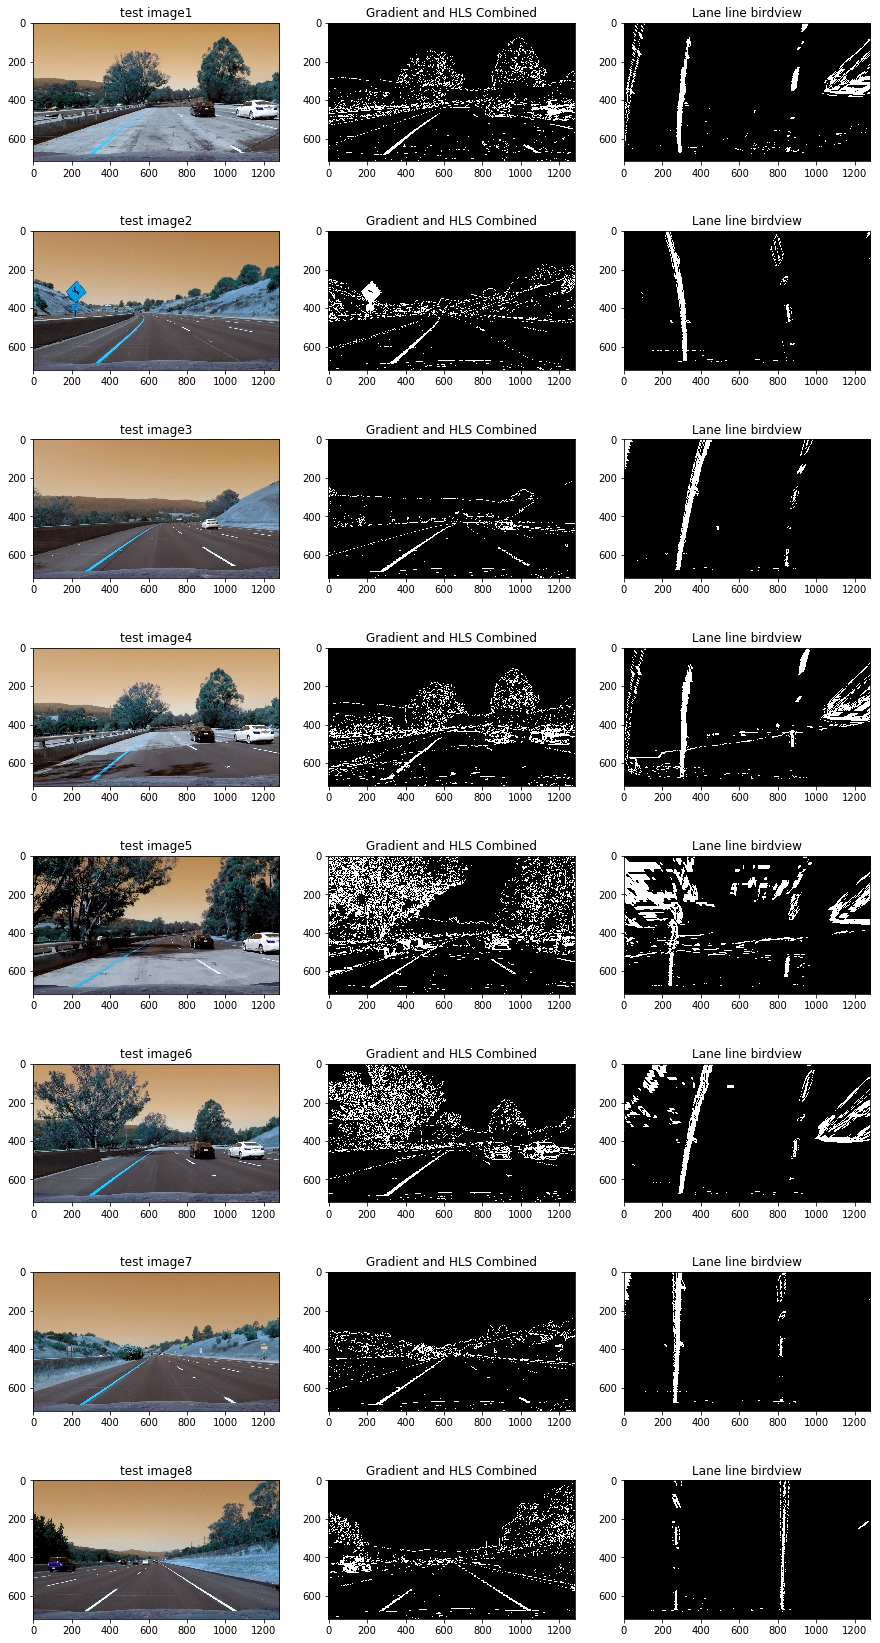

In [256]:
test_path = './test_images/'
fig = plt.figure(figsize=(15,30))
for i in range(1,9):
    img = cv2.imread(image_path + f'test{i}.jpg')
    fig.add_subplot(8,3,(i-1)*3+1)
    plt.title(f'test image{i}')
    plt.imshow(img, cmap = 'gray') 
    
    fig.add_subplot(8,3,(i-1)*3+2)
    plt.title('Gradient and HLS Combined')
    final = gradient_hls_process(img, threshold1=(35,100), threshold2=(0,np.pi/2))
    plt.imshow(final, cmap = 'gray') 

    fig.add_subplot(8,3,(i-1)*3+3)
    
    undistorted = cv2.undistort(final, mtx, dist, None, mtx)
    birdview = unwarp_image(undistorted, src, dst)
    plt.title('Lane line birdview')
    plt.imshow(birdview, cmap = 'gray') 

### Convert an original image to its binary format

In [51]:
def binary_image(image):

    ## The src and dst only work for this specific case, because camera was fixed on the vehicle, and the location of lane lines
    # in the image was almost unchanged.
    ## I am still keeping investigating a smarter algorithm to decide these points automatically.##
    
    hls = gradient_hls_process(image, threshold1=(35,100), threshold2=(0,np.pi/2))
    Minv = cv2.getPerspectiveTransform(dst, src)
    undistorted = cv2.undistort(hls, mtx, dist, None, mtx)
    binary_image = unwarp_image(undistorted, src, dst)
    return binary_image, Minv

### Finding the lines using histogram

### Now the image's binary output was obtained. Now it is time to detect lane lines. 

##### The basic idea is to divide the image to several small windows. Generally, the smaller, the better, because when the window is large, several peaks may occur, and if the largest peak happens close the midpoint, the pixels with smaller x coordinates may be located outside of the window, resulting in less robustness. In addition, with more small windows, the size of block can be reduced too, which is helpful to isolate noises. On the other side, if the window is too small, it becomes costly to calculate. I think divide the images into 4, instead of 2, is a more reasonable choice.  

In [52]:
# This function is to identify left and right lane lines

def sliding_window(binary_image):
    
    #0.75 means cut the image into 4, and only considers the 4th part to find the lane line.
    histogram = np.sum(binary_image[np.int(binary_image.shape[0]*0.5):,:], axis=0)
    out_img = np.dstack((binary_image, binary_image, binary_image))*255

    #divide the image into left and right parts, consider left and right lane lines seperately
    midpoint = np.int(histogram.shape[0]/2)

    # 0 for left, and 1 for right
    
    # find the summation peak along the columns, starting from the very bottom
    # The theory beside this is that the area close to the lane lines should have the largest number, because
    # there are a lot more pixels in that area than others. 
    
    #reduce the search area for better robustness
    xbase0 = np.argmax(histogram[:midpoint])
    xbase1 = np.argmax(histogram[midpoint:]) + midpoint
    
    # force to correct xbase if the lane lines are wrongly identified. 
    if xbase0 < 200:
        xbase0 = 200
    if xbase1 < 800:
        xbase1 = 800
    
    #Seperate the y axis of an image into 9 parts, probably this parameter can be optimized for better robustness. 
    nwin = 9
    win_height = np.int(binary_image.shape[0]/nwin)
    
    #At the beginning, use the first max value of x as the starting point for left and right
    current_xbase0 = xbase0
    current_xbase1 = xbase1
    
    # Ideally, margin should be just enough to include all pixels in the lane lines. However, due to irregularity and noise,
    # margin has to be reasonally bigger than the width of the lane line. 
    margin = 40
    
    # When the number of pixels in a sliding window exceeds this parameter, we would consider that lane line is found. 
    # However, it is also possible that the pixels found are just noise. So a reasonble parameter should be selected here. 
    minpix = 50

    left_lane = []
    right_lane = []

    for window in range(nwin):
        win_y_low = binary_image.shape[0] - (window + 1)*win_height
        win_y_high = binary_image.shape[0] - window*win_height

        #x0 stands for left lane line,and x1 for right lane line
        
        #height of one sliding window
        win_x0_left = current_xbase0 - margin
        win_x0_right = current_xbase0 + margin
        
        #width of one sliding window
        win_x1_left = current_xbase1 - margin
        win_x1_right = current_xbase1 + margin
        
        #left windonws, this function only works for top left point -> bottom right as far as know
        cv2.rectangle(out_img,(win_x0_left,win_y_low),(win_x0_right,win_y_high),(255,255,0),10)

        #right windows
        cv2.rectangle(out_img,(win_x1_left,win_y_low),(win_x1_right,win_y_high),(0,255,255),10)

        # array slicing will reset the coordinates of the array starting from 0. 
        # Therefore, we need use their acutal coordinates.

        box0 = binary_image[win_y_low:win_y_high,win_x0_left:win_x0_right].nonzero()

        box1 = binary_image[win_y_low:win_y_high,win_x1_left:win_x1_right].nonzero()
        
        block0y = box0[0] + win_y_low
        block0x = box0[1] + current_xbase0 - margin
        
        block1y = box1[0] + win_y_low
        block1x = box1[1] + current_xbase1 - margin

        box0_coord = list(zip(block0x,block0y))
        box1_coord = list(zip(block1x,block1y))
        
        if len(left_lane) == 0:
            left_lane = box0_coord
        elif len(box0_coord) == 0:
            pass
        else:
        ##here, list.append is not preferred to use, because it will cause several sub-list in the list,
        # resulting in a loop execuation to extract them later
            left_lane = np.concatenate((left_lane,box0_coord),axis = 0)
            
        if len(right_lane) == 0:
            right_lane = box1_coord
            #print(f'{window}:',len(right_lane))
        elif len(box1_coord) == 0:
            pass
        else:
            right_lane = np.concatenate((right_lane,box1_coord),axis = 0)
        
        #left_lane.append(box0_coord)
        #right_lane.append(box1_coord)
        if len(box0_coord) > minpix:
            current_xbase0 = np.int(np.mean(block0x))
        if len(box1_coord) > minpix:
            
            current_xbase1 = np.int(np.mean(block1x))

    leftx = []
    lefty = []
    
    for i in range(len(left_lane)):
        leftx.append(left_lane[i][0])
        lefty.append(left_lane[i][1])

    rightx = []
    righty = []
    
    for i in range(len(right_lane)):
        rightx.append(right_lane[i][0])
        righty.append(right_lane[i][1])
        
    #    dst = np.float32([(225,400), (900,400), (900,650), (225,650)])    
    # the polynomial function is like this x = a*y^2 + b* y + c
    # because for there are left and right lane lines.
    lx = [225,300]
    ly = [605,200]
    rx = [865,900]
    ry = [900,200]
    if len(leftx) == 0 or len(lefty) == 0:
        leftx = lx
        lefty = ly
    if len(rightx) == 0 or len(righty) == 0:
        rightx = rx
        righty = ry
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    #plt.imshow(out_img,cmap='gray')
    return left_fit, right_fit

In [53]:
def no_sliding_window(binary_image,left, right):

    #Find all the pixels that are not equal to 0
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Because the polynomial already found out, we can reduce the size of the searching area for better performance
    width = 25
    
    left_lane = ((nonzerox > (left[0]*(nonzeroy**2) + left[1]*nonzeroy + 
    left[2] - width)) & (nonzerox < (left[0]*(nonzeroy**2) + 
    left[1]*nonzeroy + left[2] + width)))
    #print('left_lane:', left_lane)
    right_lane = ((nonzerox > (right[0]*(nonzeroy**2) + right[1]*nonzeroy + 
    right[2] - width)) & (nonzerox < (right[0]*(nonzeroy**2) + 
    right[1]*nonzeroy + right[2] + width)))
    
    
    leftx = nonzerox[left_lane]
    lefty = nonzeroy[left_lane] 
    rightx = nonzerox[right_lane]
    righty = nonzeroy[right_lane]
    
    lx = [225,300]
    ly = [605,200]
    rx = [865,900]
    ry = [900,200]
    if len(leftx) == 0 or len(lefty) == 0:
        leftx = lx
        lefty = ly
    if len(rightx) == 0 or len(righty) == 0:
        rightx = rx
        righty = ry
    
    left_fit = np.polyfit(lefty, leftx, 2)

    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

## Visualization the identified polynomial and sliding windows used to construct them

### Keep searching the next frame image after the lines are identified

#### Let's assume the test image is just the next frame image respectively


Left lane curve: 944.028 m Right lane curve: 1230.395 m deviation to the right: 0.376 m
Left lane curve: 685.437 m Right lane curve: 561.611 m deviation to the right: 0.343 m
Left lane curve: 1890.373 m Right lane curve: 1067.584 m deviation to the right: 0.452 m
Left lane curve: 1288.388 m Right lane curve: 570.766 m deviation to the right: 0.252 m
Left lane curve: 5277.936 m Right lane curve: 3183.359 m deviation to the right: 0.554 m
Left lane curve: 1941.702 m Right lane curve: 844.161 m deviation to the right: 0.314 m
Left lane curve: 5472.725 m Right lane curve: 5533.127 m deviation to the right: 0.539 m
Left lane curve: 5976.647 m Right lane curve: 55389.299 m deviation to the right: 0.511 m


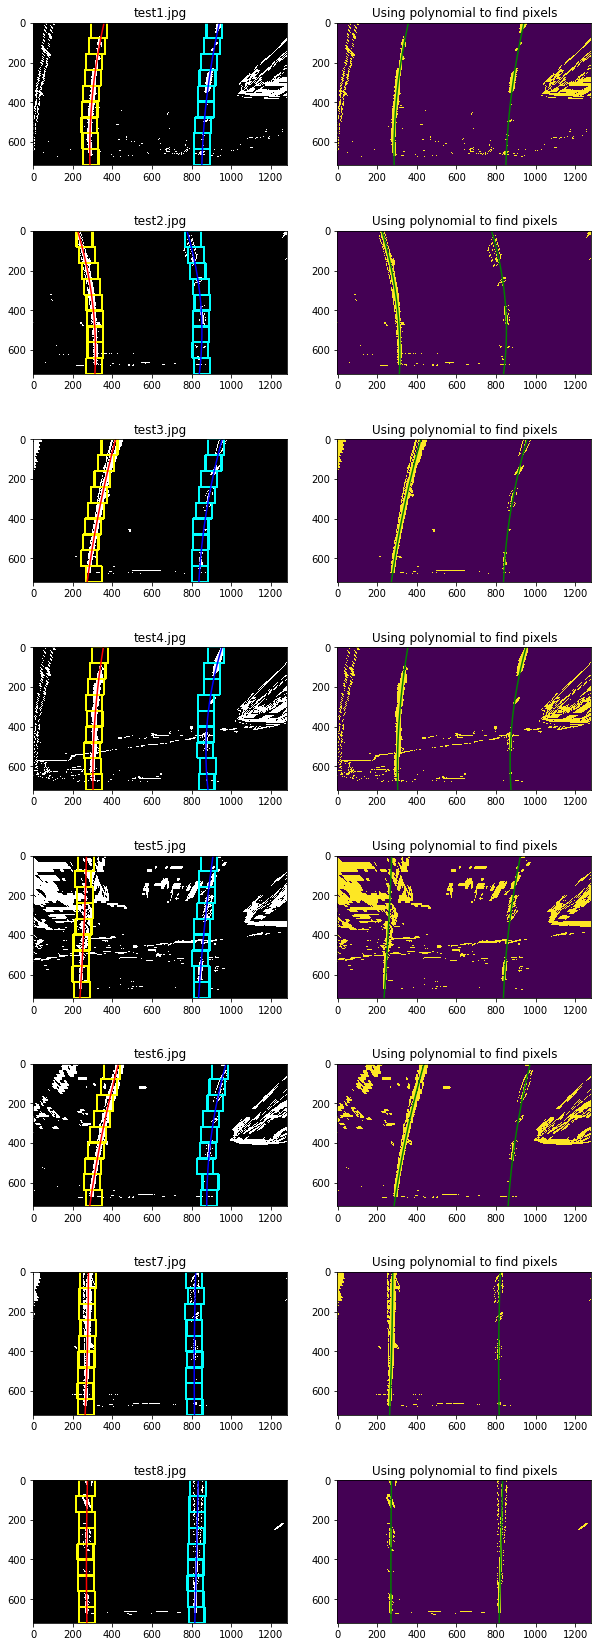

In [370]:
test_path = './test_images/'
fig = plt.figure(figsize=(10,30))

for i in range(1,9):
    img = cv2.imread(test_path + f'test{i}.jpg')
    binary = binary_image(img)
    fig.add_subplot(8,2,i*2-1)
    plt.title(f'test{i}.jpg')
    left_fit, right_fit = sliding_window(binary)
    
    #here,if the function was y = a*x^2+b*x+c, we would need 2 plotx, not convenient! 
    ploty = np.linspace(0,719,720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='blue')
    
    fig.add_subplot(8,2,i*2)
    plt.title('Using polynomial to find pixels')
    
    left_lane,right_lane = no_sliding_window(binary,left_fit,right_fit)
    left_fitx_new = left_lane[0]*ploty**2 + left_lane[1]*ploty + left_lane[2]
    right_fitx_new = right_lane[0]*ploty**2 + right_lane[1]*ploty + right_lane[2]
    
    plt.plot(left_fitx_new, ploty, color='green')
    plt.plot(right_fitx_new, ploty, color='green')
    plt.imshow(binary)
    
    left_fit = pixel2meter(left_fit)
    right_fit = pixel2meter(right_fit)
    
    y_eval = 30
    left_curverad = round(((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0]),3)
    right_curverad = round(((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0]),3)
    
    devia = round(deviation(binary,left_fit, right_fit),3)
    
    if devia >=0:
        print('Left lane curve:',left_curverad, 'm', 'Right lane curve:',right_curverad,'m', 'deviation to the left:',devia,'m')
    if devia <0:
        print('Left lane curve:',left_curverad, 'm', 'Right lane curve:',right_curverad,'m', 'deviation to the right:',-devia,'m')

In [54]:
## Car deviation from the center function
def deviation(img,left_fit,right_fit):
    car_position = img.shape[1]/2
    
    ym = 30/720 # meters per pixel in y dimension
    xm = 3.7/700 # meters per pixel in x dimension
    
    car_center = car_position*xm
    
    # find the bottom y value in meter
    h = img.shape[0]*ym
    
    x0 = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    x1 = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    
    devia = (x0 + x1)/2 - car_center
    return devia

In [55]:
def pixel2meter(fit):
    ## The coefficients of polynomial are for the pixels, not for meter in reality. Conversion is needed here. 
    # Define conversions in x and y from pixels space to meters
    
    my = 30/720 # meters per pixel in y dimension
    mx = 3.7/700 # meters per pixel in x dimension
    
    fit_meter = []
    fit_meter.append(fit[0]*mx/(my**2))
    fit_meter.append(mx/my*fit[1])
    fit_meter.append(fit[2]*mx)
    return fit_meter

### Show the lane line area in the original image

In [56]:
def plotregion(orig_image,binary, left, right, Minv):
    region_h = binary.shape[0]
    ploty = np.linspace(0,region_h-1, region_h)
    
    leftx = left[0]*ploty**2 + left[1]*ploty + left[2]
    rightx = right[0]*ploty**2 + right[1]*ploty + right[2]
    
    region = np.zeros_like(binary).astype(np.uint8)
    
    color_warp = np.dstack((region, region, region))
    XX, YY = np.meshgrid(np.arange(0, binary.shape[1]), np.arange(0, binary.shape[0]))

    #because y=AX+B, any points in YY satisfy the conditions are in the region we desire
    region_area = (XX > (left[0]*YY**2+ YY*left[1] + left[2])) & \
                    (XX < (right[0]*YY**2+ YY*right[1] + right[2]))
        
    #highlight the lanes in the desired region
    color_warp[region_area] = [190,70,50]
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary.shape[1], binary.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.5, 0)

    return result

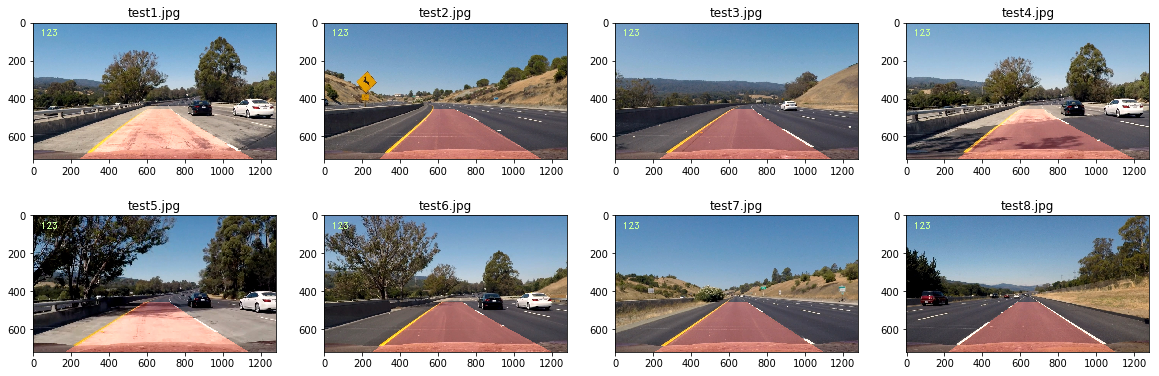

In [476]:
test_path = './test_images/'
fig = plt.figure(figsize=(20,6.5))
for i in range(1,9):
    fig.add_subplot(2,4,i)
    plt.title(f'test{i}.jpg')
    img = cv2.imread(test_path + f'test{i}.jpg')
    binary = binary_image(img)
    left_fit, right_fit = sliding_window(binary)
    
    img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    final = plotregion(img1,binary, left_fit, right_fit)

    plt.imshow(final)

## Create a pipeline to process videos

In [57]:
def annotate(img, left, right):
    
    left_fit = pixel2meter(left) #in meter
    right_fit = pixel2meter(right) #in meter
    
    y_eval = 30 #check the lane line curature at the bottom
    left_curverad = round(((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0]),3)
    right_curverad = round(((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0]),3)
    
    devia = round(deviation(img,left_fit, right_fit),3)
    
    text = f'left_lane_curve: {left_curverad} meter'
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img,text,(40,70),font, 1, (200,255,155), 2, cv2.LINE_AA)
    
    if devia >=0:
        text = f'deviation to the left {devia} meter'
    if devia <0:
        text = f'deviation to the right {-devia} meter'
    cv2.putText(img,text,(40,120),font, 1, (200,255,155), 2, cv2.LINE_AA)
    return img

In [58]:
def pipeline(image):
    
    #1. Convert a colored image to binary format, gradient direction and HLS, undistort, and warp processed are also included
    #in this function. Inverse perspective matrix also calculated here for later use. 
    binary_out, Minv = binary_image(image)
    global left_lane_in_pixel
    global right_lane_in_pixel
    
    if len(left_lane_in_pixel) == 0 or len(right_lane_in_pixel) == 0:
        left_lane_in_pixel, right_lane_in_pixel = sliding_window(binary_out)
    else: 
        left_lane_in_pixel, right_lane_in_pixel = no_sliding_window(binary_out,left_lane_in_pixel,right_lane_in_pixel)
    
    result = plotregion(image, binary_out, left_lane_in_pixel, right_lane_in_pixel, Minv)
    
    result = annotate(result,left_lane_in_pixel,right_lane_in_pixel)
    return result

### Test pipeline on an image

In [59]:
left_lane_in_pixel = []
right_lane_in_pixel = []

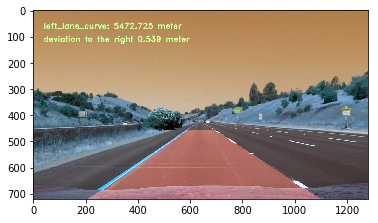

In [26]:
test_path = './test_images/'
img = cv2.imread(test_path + 'test7.jpg')
xxx = pipeline(img)
plt.imshow(xxx)

## Try selected images from Challenge video

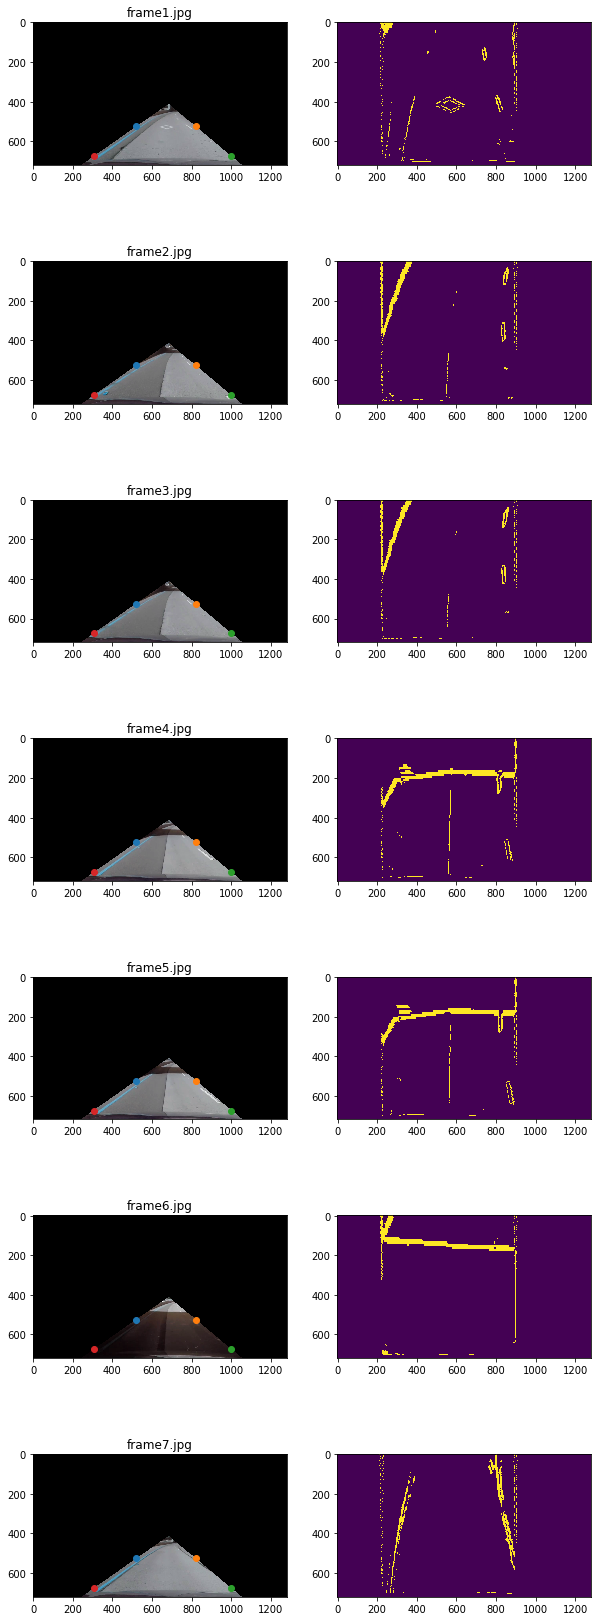

In [71]:
src = np.float32([(520,525), (820,525), (1000,675), (305,675)])
dst = np.float32([(225,400), (900,400), (900,675), (225,675)])

XX, YY = np.meshgrid(np.arange(0, 1280), np.arange(0, 720))

#because y=AX+B, any points in YY satisfy the conditions are in the region we desire
region_area = ((XX > (-1.43*YY + 1270.75)) & (XX < (1.2*YY+ 190)))

#highlight the lanes in the desired region
#color_warp[~region_area] = [0,0,0]

path = './challenge/'
fig = plt.figure(figsize=(10,30))
for i in range(1,8):
  #  left_lane_in_pixel = []
  #  right_lane_in_pixel = []
    fig.add_subplot(7,2,(i-1)*2+1)
    plt.title(f'frame{i}.jpg')
    img = cv2.imread(path + f'frame{i}.jpg')
    
    img[~region_area] = [0,0,0]
    plt.imshow(img)
    #xxx = pipeline(img)
    plt.plot(520,525,'o')
    plt.plot(820,525,'o')
    plt.plot(1000,675,'o')
    plt.plot(305,675,'o')
    #plt.imshow(xxx)

    fig.add_subplot(7,2,(i-1)*2+2)
    binary, Minv = binary_image(img)
    plt.imshow(binary)

## Video processing

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
left_lane_in_pixel = []
right_lane_in_pixel = []

# nonlocal parameters to define the lane line area
src = np.float32([(505,500), (800,500), (1100,650), (260,650)])
dst = np.float32([(225,400), (900,400), (900,650), (225,650)])

In [29]:
output = 'project_video_output1.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(pipeline) 
project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output1.mp4
[MoviePy] Writing video project_video_output1.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:20<00:00,  4.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output1.mp4 



In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [72]:
left_lane_in_pixel = []
right_lane_in_pixel = []

In [73]:
output = 'challenge_video_output1.mp4'

clip2 = VideoFileClip("challenge_video.mp4")

chanllenge_clip = clip2.fl_image(pipeline) 
chanllenge_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_output1.mp4
[MoviePy] Writing video challenge_video_output1.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:35<00:00,  5.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output1.mp4 



In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))